# Machine Failure Prediction using Machine Learning
Author: Chen ZhuoFan (P2100746) | Singapore Polytechnic

Globalisation is the process of interaction and integration among people,companies and governments worldwide.It has accelerated since the 18th century and have enabled the trade of goods and services at a bigger scale.

The production of goods need to be done more effectively.In today's world, many goods are manufacturing by machines in a pipeline to ensure high efficiency and precision at the same time. However,machines may malfunction with time.These malfunctioning machines may result in defects in goods which is not favourable. Manual checking can be time-consuming and cost-inefficient.

Machine Learning is defined by Mitchell (1997) as the study of computer algorithms that improve automatically through experience. [3] Machine learning comes to our sight in the recent decades with its ease and high performance. It has the capacity to learn and identify patterns from data and make decision.

In this experiment ,we will make use of machine learning model to assist us in predicting malfunctioning machines so that repairs or replacements can be done in time to reduce disruption and loss.


## Problem Statement

How can we make use of machine learning to predict malfunctioning machines in the factories?

## Importing Libraries

In [208]:
!pip install numpy matplotlib pandas seaborn sklearn yellowbrick phik statsmodels pyampute xgboost imblearn

You should consider upgrading via the 'C:\Users\zhuof\PycharmProjects\classificationCA1\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [209]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")



# Model Evaluation
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, plot_precision_recall_curve, plot_roc_curve, confusion_matrix
from yellowbrick.model_selection import learning_curve

# Missing Value
from pyampute.exploration.mcar_statistical_tests import MCARTest
from sklearn.impute import KNNImputer



# Data Preprocessing
import phik
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  OneHotEncoder
from sklearn.preprocessing import  MinMaxScaler


# Models
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb


# Feature Importance
from sklearn.inspection import permutation_importance

# Hyperparameter Tuning
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import recall_score

# Feature Selection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest,chi2


# Random State
random_state = 0

## Data Ingestion

In [210]:
machineDf=pd.read_csv("./factory_data (classification).csv",index_col='Unique ID')
machineDf

,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
Unique ID,,,,,,,,
1,K12965,M,24.95,35.45,1551.0,42.8,0,0
2,Z62710,L,25.05,35.55,1408.0,46.3,3,0
3,T20224,L,24.95,35.35,1498.0,49.4,5,0
4,Z33024,L,25.05,35.45,1433.0,39.5,7,0
5,Z52839,L,25.05,35.55,1408.0,40.0,9,0
...,...,...,...,...,...,...,...,...
19996,T87335,M,25.75,35.35,NaN,29.5,14,0
19997,Z59525,H,25.85,35.35,1632.0,31.8,17,0
19998,T83921,M,25.95,NaN,NaN,33.4,22,0


## Data Exploration

### Data Structure

In [211]:
machineDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 1 to 20000
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Product ID            20000 non-null  object 
 1   Quality               19009 non-null  object 
 2   Ambient T (C)         20000 non-null  float64
 3   Process T (C)         19600 non-null  float64
 4   Rotation Speed (rpm)  18812 non-null  float64
 5   Torque (Nm)           20000 non-null  float64
 6   Tool Wear (min)       20000 non-null  int64  
 7   Machine Status        20000 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 1.4+ MB


### Managing Missing Data

In [212]:
pd.DataFrame(machineDf.isna().sum().sort_values(ascending=False))

,0
Rotation Speed (rpm),1188
Quality,991
Process T (C),400
Product ID,0
Ambient T (C),0
Torque (Nm),0
Tool Wear (min),0
Machine Status,0


In [213]:
machineDf[machineDf.isnull().any(axis=1)]

,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
Unique ID,,,,,,,,
7,K40563,L,24.95,NaN,NaN,42.4,14,0
11,K30974,NaN,25.25,35.75,1782.0,23.9,24,0
15,T39889,NaN,25.45,36.05,2035.0,19.6,40,0
20,T81915,M,25.75,NaN,1632.0,32.5,55,0
21,S64787,H,25.75,36.15,NaN,42.7,58,0
...,...,...,...,...,...,...,...,...
19982,Z53954,L,25.65,NaN,1353.0,47.0,190,0
19987,S13645,M,25.75,35.55,NaN,42.3,207,0
19992,T72209,M,25.85,35.35,NaN,26.1,5,0


<AxesSubplot:title={'center':'Number of missing value in features'}>

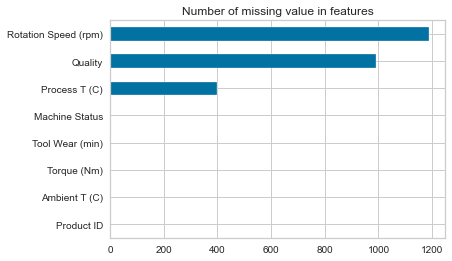

In [214]:
machineDf.isna().sum().sort_values().plot.barh(title='Number of missing value in features')

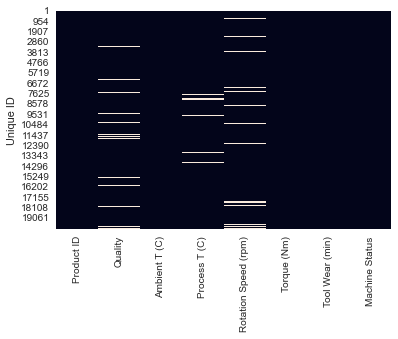

In [215]:
import seaborn as sns
sns.heatmap(machineDf.isnull(), cbar=False)
plt.show()

<AxesSubplot:>

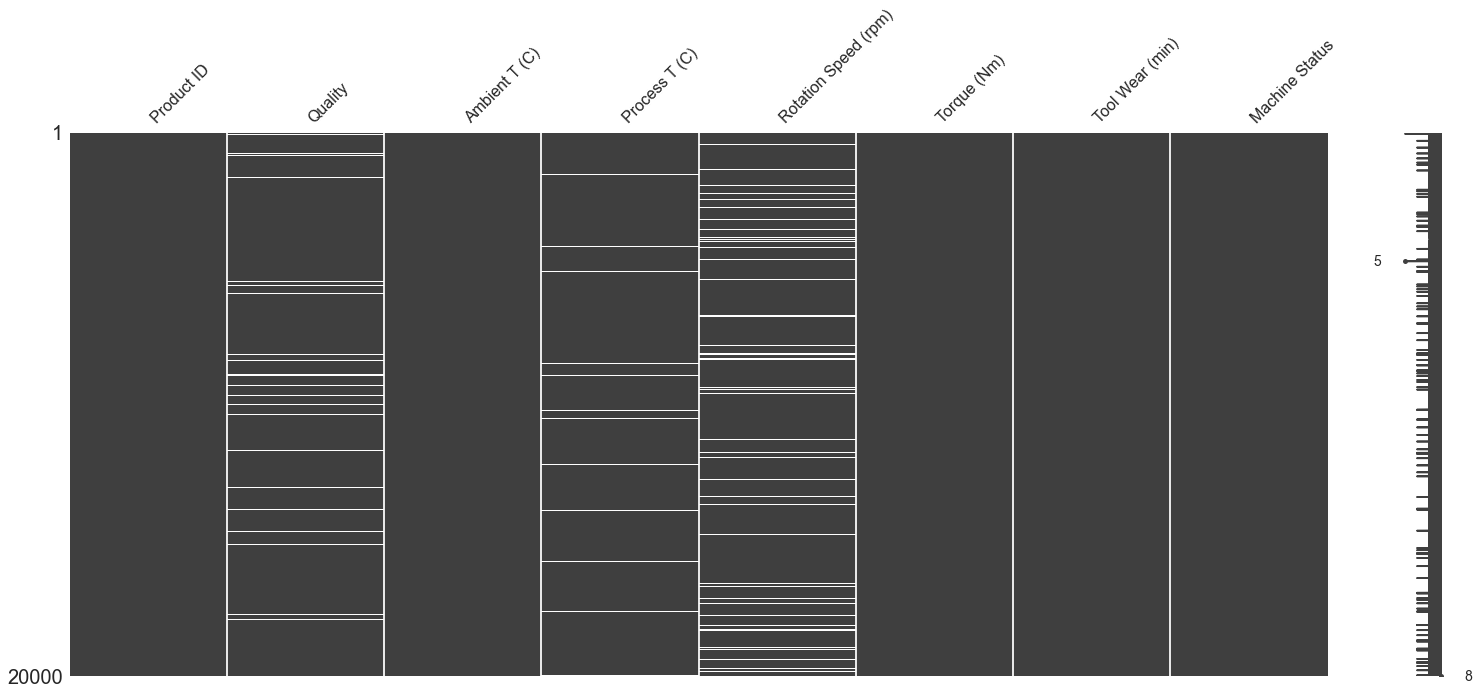

In [216]:
import missingno as msno
msno.matrix(machineDf)

<AxesSubplot:>

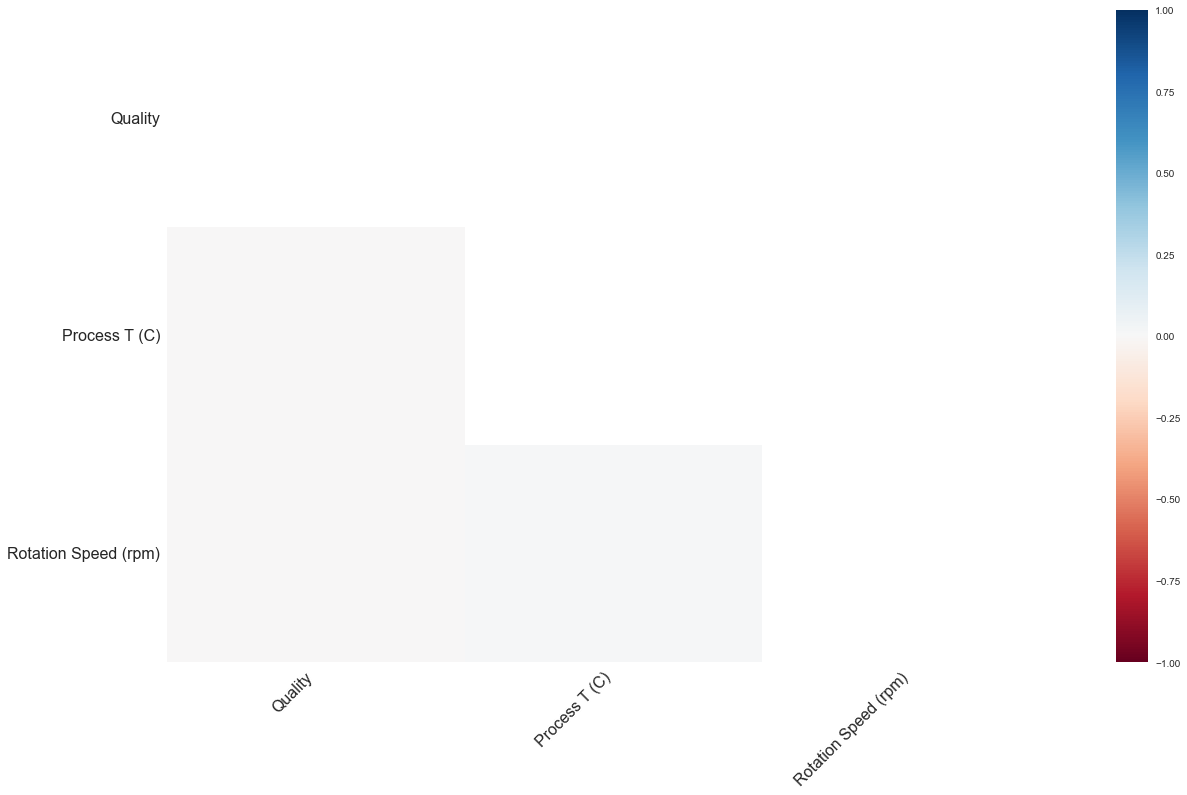

In [217]:
msno.heatmap(machineDf)

### Target Label

Text(0.5, 1.0, 'Distribution of target label')

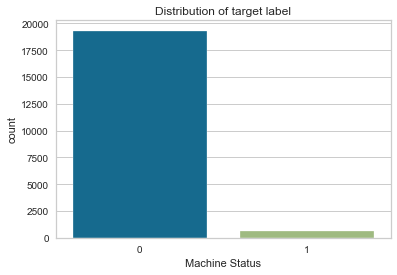

In [218]:
sns.countplot(data=machineDf,x='Machine Status').set_title("Distribution of target label")

### Qualitative Features

In [219]:
qualitativeVariable=['Product ID', 'Quality']

### Qualitative Features

In [220]:
quantitativeVariable=['Ambient T (C)', 'Process T (C)',
       'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)']

### Univariate Analysis

In [221]:
machineDf[quantitativeVariable].describe()

,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min)
count,20000.000000,19600.000000,18812.000000,20000.000000,20000.000000
mean,26.904930,36.904291,1538.795397,39.986910,107.951000
std,2.000834,1.483647,178.674963,9.968684,63.652555
min,22.150000,32.550000,1168.000000,3.800000,0.000000
25%,25.250000,35.750000,1423.000000,33.200000,53.000000
50%,26.950000,36.950000,1503.000000,40.100000,108.000000
75%,28.450000,37.950000,1613.000000,46.800000,162.000000
max,31.450000,40.750000,2886.000000,76.600000,253.000000


In [222]:
descriptive_stats = machineDf.astype('category').describe().T
descriptive_stats["Proportion of Most Frequent Value"] = descriptive_stats["freq"] / len(machineDf.astype('category')) * 100
descriptive_stats.sort_values("Proportion of Most Frequent Value", ascending=False)

,count,unique,top,freq,Proportion of Most Frequent Value
Machine Status,20000,2,0,19322,96.61
Quality,19009,3,L,11390,56.95
Process T (C),19600.0,83.0,37.45,575.0,2.875
Ambient T (C),20000.0,94.0,27.55,495.0,2.475
Tool Wear (min),20000,246,0,240,1.2
Torque (Nm),20000.0,577.0,40.2,104.0,0.52
Rotation Speed (rpm),18812.0,941.0,1452.0,93.0,0.465
Product ID,20000,19408,K34631,3,0.015


<AxesSubplot:xlabel='Quality', ylabel='count'>

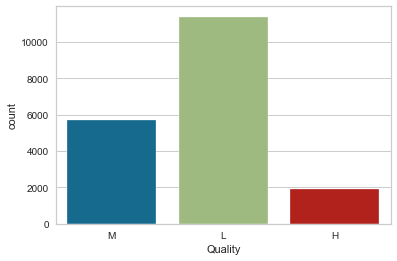

In [223]:
sns.countplot(x='Quality',data=machineDf,)

array([[<AxesSubplot:title={'center':'Ambient T (C)'}>,
        <AxesSubplot:title={'center':'Process T (C)'}>],
       [<AxesSubplot:title={'center':'Rotation Speed (rpm)'}>,
        <AxesSubplot:title={'center':'Torque (Nm)'}>],
       [<AxesSubplot:title={'center':'Tool Wear (min)'}>, <AxesSubplot:>]],
      dtype=object)

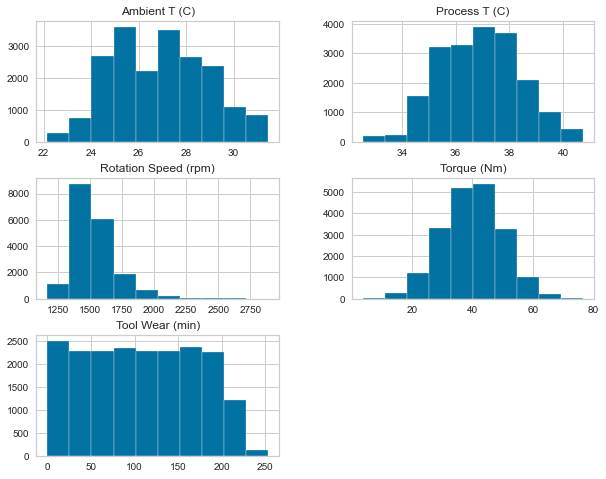

In [224]:
machineDf[quantitativeVariable].hist(figsize=(10,8))

C:\Users\zhuof\AppData\Local\Temp\ipykernel_2696\68958518.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


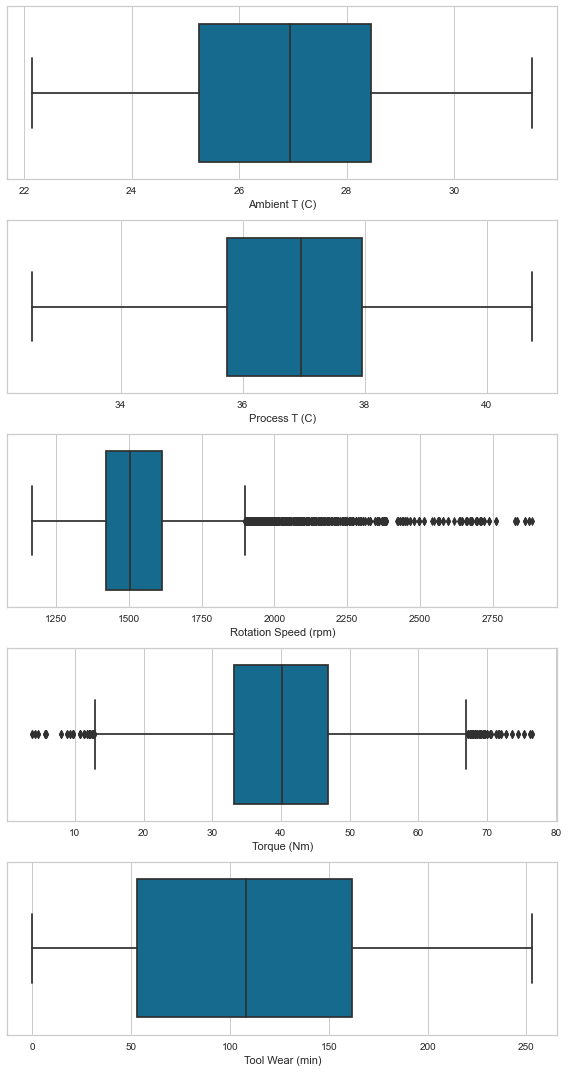

In [225]:
fig, ax = plt.subplots(len(quantitativeVariable), 1, figsize=(8, 15), tight_layout=True)
for idx, feature in enumerate(quantitativeVariable):
    sns.boxplot(data=machineDf, x=feature, ax = ax[idx])
fig.show()

In [226]:
Q1 = machineDf['Rotation Speed (rpm)'].quantile(0.25)
Q3 = machineDf['Rotation Speed (rpm)'].quantile(0.75)
IQR = Q3 - Q1
machineDf[machineDf['Rotation Speed (rpm)'] >Q3 + 1.5 * IQR].describe()

,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
count,771.000000,757.000000,771.000000,771.000000,771.000000,771.000000
mean,27.163230,37.031242,2103.333333,18.846174,107.712062,0.084306
std,2.062808,1.507887,216.956317,3.588364,65.390417,0.278027
min,22.450000,32.850000,1899.000000,3.800000,0.000000,0.000000
25%,25.350000,35.950000,1950.500000,16.800000,45.000000,0.000000
50%,27.450000,37.250000,2016.000000,19.700000,110.000000,0.000000
75%,28.750000,38.050000,2182.000000,21.500000,165.000000,0.000000
max,31.250000,40.650000,2886.000000,25.000000,244.000000,1.000000


Text(0.5, 1.0, 'Relationship between Torque and Rotation Speed')

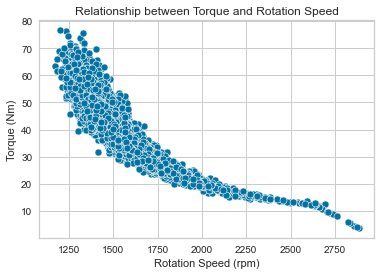

In [227]:
sns.scatterplot(x='Rotation Speed (rpm)',y='Torque (Nm)',data=machineDf).set_title('Relationship between Torque and Rotation Speed')

### Bivariate Analysis

C:\Users\zhuof\AppData\Local\Temp\ipykernel_2696\2637474119.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


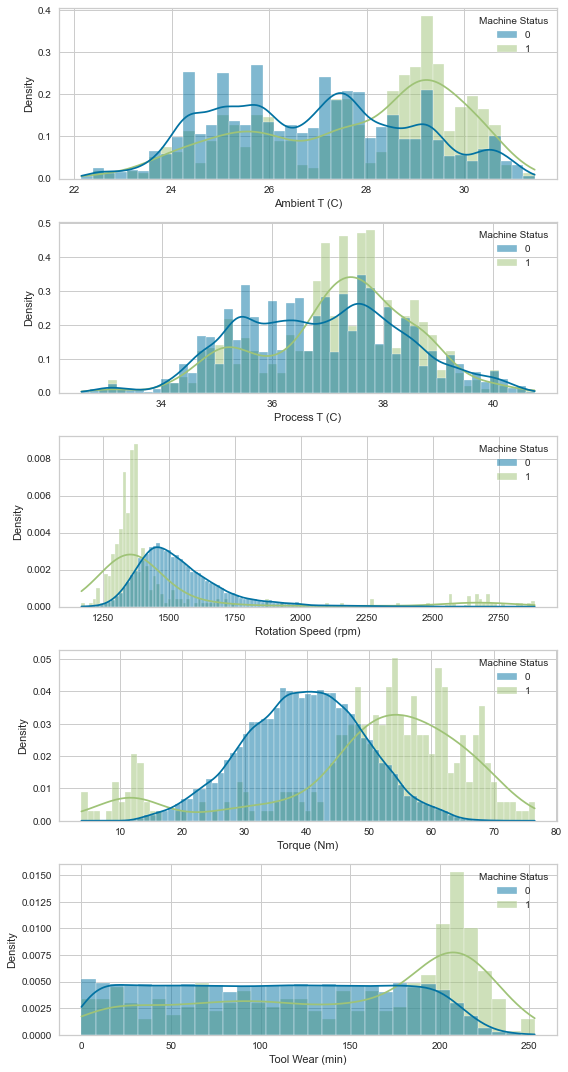

In [228]:
fig, ax = plt.subplots(len(quantitativeVariable), 1, figsize=(8, 15), tight_layout=True)
for idx, feature in enumerate(quantitativeVariable):

    sns.histplot(data=machineDf,common_norm = False,stat='density', x=feature, hue="Machine Status",ax=ax[idx],kde=True)
fig.show()

<AxesSubplot:xlabel='Quality', ylabel='Density'>

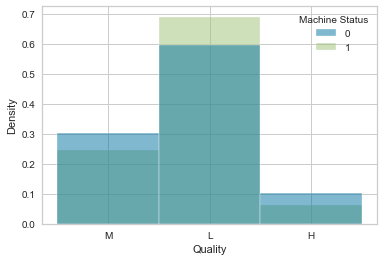

In [229]:

sns.histplot(data=machineDf,common_norm = False,stat='density', x='Quality', hue="Machine Status")


<AxesSubplot:xlabel='Quality', ylabel='count'>

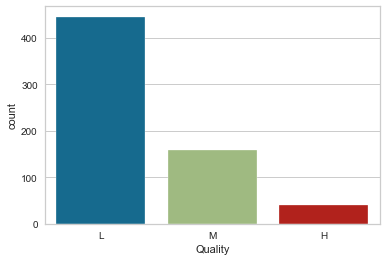

In [230]:
sns.countplot(data=machineDf[machineDf['Machine Status']>0],x='Quality')

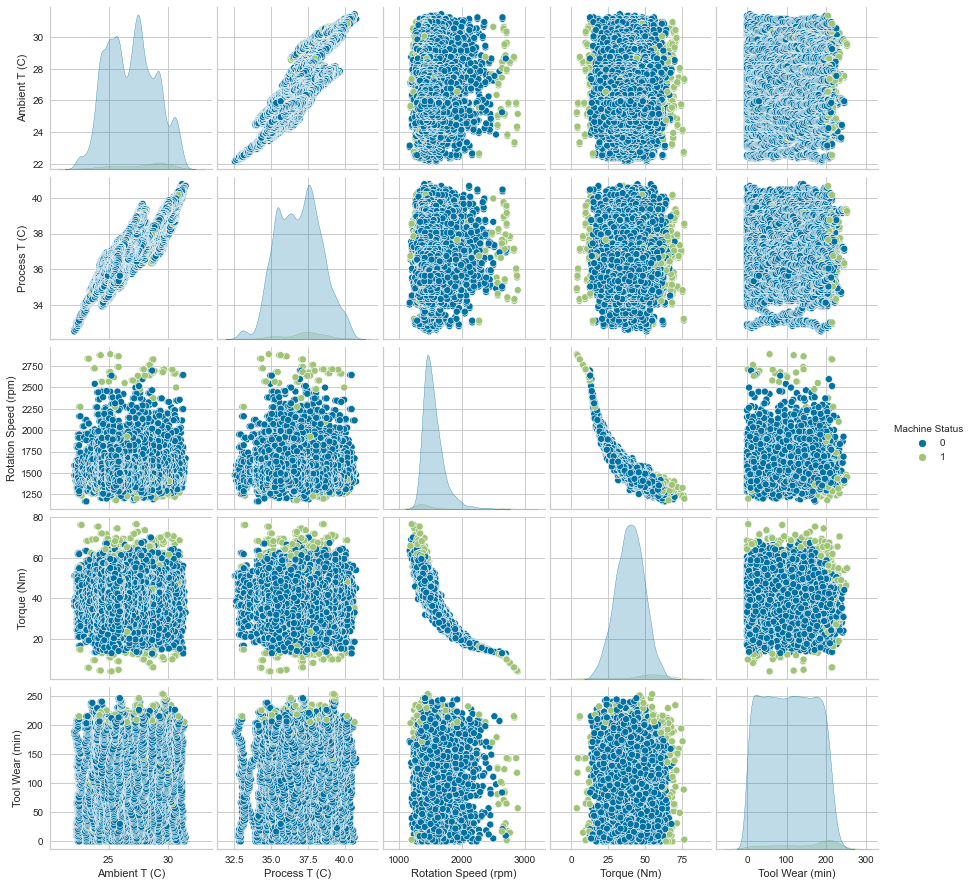

In [231]:
sns.pairplot(machineDf, hue="Machine Status")

interval columns not set, guessing: ['Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)', 'Machine Status']


C:\Users\zhuof\PycharmProjects\classificationCA1\venv\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable Product ID is large: 19408. Are you sure this is not an interval variable? Analysis for pairs of variables including Product ID can be slow.
  warnings.warn(


Text(0.5, 1.0, 'Correlation Matrix')

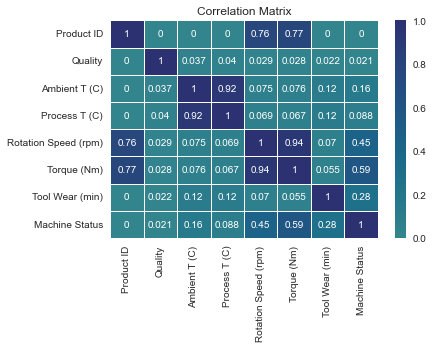

In [232]:
corr_matrix = machineDf.phik_matrix()

sns.heatmap(corr_matrix, annot = True, linewidths=.5,center = 0,cmap="crest").set_title('Correlation Matrix')

In [233]:
machineDf=machineDf.drop('Product ID',axis=1)

## Data-Processing

### Missing data imputation

In [234]:
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


categorical = ['Quality']
numerical = ['Ambient T (C)', 'Process T (C)',
       'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)']

machineDf[categorical] = machineDf[categorical].apply(lambda series: pd.Series(
    LabelEncoder().fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))



data_preprocessing = ColumnTransformer([
    ('Preprocess Numerical Features', LabelEncoder(), categorical)
])
ImputerPip=Pipeline([
     ('Encoder',data_preprocessing),
     ('Model',RandomForestClassifier)
])

imp_num = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1),
                           initial_strategy='mean',
                           max_iter=10, random_state=0)
imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1),
                           initial_strategy='most_frequent',
                           max_iter=10, random_state=0)
print(0)
machineDf[numerical] = imp_num.fit_transform(machineDf[numerical])
print(1)
machineDf[categorical] = imp_cat.fit_transform(machineDf[categorical])
print(2)
print(machineDf)

0


C:\Users\zhuof\PycharmProjects\classificationCA1\venv\lib\site-packages\sklearn\impute\_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


1
2
           Quality  Ambient T (C)  Process T (C)  Rotation Speed (rpm)  \
Unique ID                                                                
1              2.0          24.95         35.450               1551.00   
2              1.0          25.05         35.550               1408.00   
3              1.0          24.95         35.350               1498.00   
4              1.0          25.05         35.450               1433.00   
5              1.0          25.05         35.550               1408.00   
...            ...            ...            ...                   ...   
19996          2.0          25.75         35.350               1642.72   
19997          0.0          25.85         35.350               1632.00   
19998          2.0          25.95         36.691               1597.29   
19999          0.0          25.95         35.650               1408.00   
20000          2.0          25.95         35.650               1500.00   

           Torque (Nm)  Tool Wear

### Oversampling :SMOTE NC

In [235]:
from imblearn.over_sampling import SMOTENC

colselect=[col in qualitativeVariable for col in machineDf. loc[:, machineDf. columns != 'Machine Status'].columns]
x,y=SMOTENC(random_state=42, categorical_features=colselect).fit_resample(machineDf. loc[:, machineDf. columns != 'Machine Status'],machineDf['Machine Status'])

## Feature Scaling

In [236]:
from sklearn.preprocessing import StandardScaler

quantitativeTransformer=Pipeline([

     ('Normaliser',MinMaxScaler())
])
categorical_transformers = Pipeline([
    ('One Hot Encoder', OneHotEncoder(handle_unknown='ignore'))
])
data_preprocessing = ColumnTransformer([
    ('Preprocess Numerical Features', quantitativeTransformer, quantitativeVariable),
       ('Preprocess Categorical Features', categorical_transformers, ['Quality'])
])

## Training and testing data

In [237]:
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state = 42, stratify=y, test_size = .20)
x_train

,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min)
24590,1.0,29.268097,37.136987,1368.226916,51.254292,35.409514
36372,2.0,27.110532,38.485417,1394.307419,48.169098,221.820602
31171,1.0,29.450000,37.533849,1328.221364,58.856499,95.221364
27443,1.0,29.642680,38.142680,1377.000000,45.265204,26.283782
11525,1.0,25.150000,35.950000,2449.000000,13.800000,45.000000
...,...,...,...,...,...,...
23493,1.0,30.914273,39.814273,1363.000000,62.500000,200.000000
12409,1.0,26.050000,35.450000,1539.000000,46.800000,190.000000
18063,2.0,27.250000,37.719000,1551.000000,36.400000,84.000000
3715,2.0,29.250000,38.250000,1475.000000,45.200000,46.000000


## Feature Selection

In [238]:
# selectionRecord=pd.DataFrame({'no':[],'score':[]})
# for i in range(1,9):
#     Final = Pipeline([
#     ('Data Preprocessing', data_preprocessing),
#     ('Kbest',SelectKBest(chi2,k=i)),
#     ('Model',   xgb.XGBClassifier())
# ])
#     selectionRecord=pd.concat([selectionRecord,pd.DataFrame({'no':[i],'score':[cross_validate(Final,x_train,y_train,cv=StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0,),scoring=['recall'],n_jobs=-1,return_estimator=True,return_train_score=True)['test_recall'].mean()]})],ignore_index=True)
#
#
# sns.lineplot(x='no',y='score',data=selectionRecord).set_title('Number of feature selected')

In [239]:
# from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Final = Pipeline([
#     ('Data Preprocessing', data_preprocessing),
#     ('Model',   xgb.XGBClassifier())
# ])
# sfs1 = SFS(xgb.XGBClassifier(),
#            k_features=(1, 8),
#            forward=True,
#            floating=False,
#            verbose=2,
#            scoring='recall',
#            cv=StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0,))
# sfs1.fit(pd.DataFrame(data_preprocessing.fit_transform(x_train,y_train)),y_train)
# print('best combination (ACC: %.3f): %s\n' % (sfs1.k_score_, sfs1.k_feature_idx_))
# print('all subsets:\n', sfs1.subsets_)
# plot_sfs(sfs1.get_metric_dict(), kind='std_err');

In [240]:
# pd.DataFrame({'Methods':['Chi-Square','Forward Sequential Feature Selector'],'Type':['Filter','Wrapper'],'Best number of feature':[selectionRecord.score.idxmax()+1,pd.DataFrame(sfs1.get_metric_dict()).T.avg_score.astype('f8').idxmax()],'Score':[selectionRecord.score[selectionRecord.score.idxmax()],   pd.DataFrame(sfs1.get_metric_dict()).T.avg_score[pd.DataFrame(sfs1.get_metric_dict()).T.avg_score.astype('f8').idxmax()] ]})

In [241]:
class customSelector():
    def __init__(self):
        super().__init__()

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

    def transform(self, X, y=None):
        return pd.DataFrame(X)[[0,1,2,3,4,5,6]]

    def fit(self, X, y=None):
        return self

## Evaluation Methodology

In [242]:
def scoreModel(clf,x,y,algName=None,record=pd.DataFrame({'name':[],'train_accuracy':[],'test_accuracy':[],'test_recall':[],'train_recall':[]})):
    '''
    This function is used for model evaluation . This function use scikit-learn library to carry out cross validation using StratifiedKFold. The scoring metrics are accuracy and balanced accuracy

    :param clf: Classifier 分类器
    :param x:Train Data X(Data)  训练数据 （数据）
    :param y:Train Data Y(Result)  训练数据（结果）
    :param algName: Name of Algorithm used for recording 算法名字
    :param record: History record dataframe 在历史记录上叠加结果
    :return:
    This function return 3 variable: 这个函数返回三个参数
    record: Dataframe with current and past record(if there is any)
    current: Dataframe with current record
    lr: Learning curve
    '''
    score=cross_validate(clf,x,y,cv=StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0,),scoring=['accuracy','recall'],n_jobs=-1,return_estimator=True,return_train_score=True)
    current=pd.DataFrame({'name':[algName],'train_accuracy':score['train_accuracy'].mean(),'test_accuracy':score['test_accuracy'].mean(),'test_recall':score['test_recall'].mean(),'train_recall':score['train_recall'].mean()})
    record=pd.concat([record,current],ignore_index=True)
    lr = learning_curve(clf, x, y, scoring = 'recall', cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0,), n_jobs=-1)
    return record,current,lr

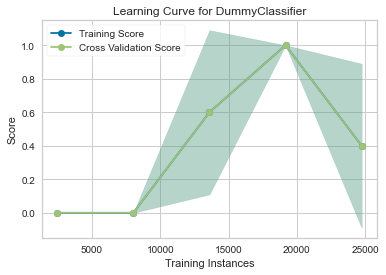

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Dummy Baseline Classifier,0.500016,0.499919,0.4,0.4


In [246]:
from sklearn.feature_selection import chi2

baseline = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Custom Selector',customSelector()),
    ('Model', DummyClassifier())
])
record,current,lr=scoreModel(baseline,x_train,y_train,"Dummy Baseline Classifier")
current

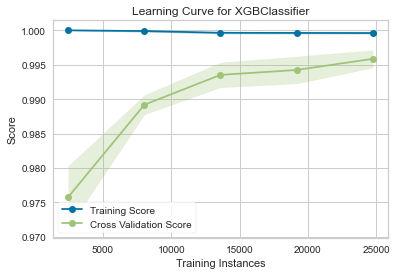

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,eXtreme Gradient Boosting Classifier,0.999466,0.992981,0.99586,0.999612


In [247]:

xgboost = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Custom Selector',customSelector()),
    ('Model', xgb.XGBClassifier())
])
record,current,lr=scoreModel(xgboost,x_train,y_train,"eXtreme Gradient Boosting Classifier",record)
current

In [248]:
record

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Dummy Baseline Classifier,0.500016,0.499919,0.40000,0.400000
1,eXtreme Gradient Boosting Classifier,0.999466,0.992981,0.99586,0.999612
